In [41]:
from datasets import load_dataset
from collections import defaultdict
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import torch.nn as nn
import torch.optim as optim
import pandas as pd

device = 'cpu'#'cuda' if torch.cuda.is_available() else 'cpu'

## Clinical Only

In [2]:
class ClinicalSurvivalDataset(Dataset):
    def __init__(self, hf_dataset, survival_days=730):
        self.samples = []
        for item in hf_dataset:
            if item["days_to_death"] is not None:
                embedding = np.frombuffer(item["embedding"], dtype=np.float32)
                embedding = embedding.reshape(item["embedding_shape"])
                label = 1 if int(item["days_to_death"]) >= survival_days else 0
                self.samples.append((embedding, label))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        embedding, label = self.samples[idx]
        return torch.tensor(embedding, dtype=torch.float32), torch.tensor(label, dtype=torch.float32)

In [3]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

In [15]:
clinical_dataset = load_dataset("Lab-Rasool/TCGA", "clinical", split="gatortron")
dataset = ClinicalSurvivalDataset(clinical_dataset)

# Split into train and val
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [16]:
sample_input, _ = next(iter(train_loader))
input_dim =  sample_input.view(sample_input.size(0), -1).shape[1] 

model = MLP(input_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=5e-4)

In [17]:
def train(model, loader):
    model.train()
    total_loss = 0
    for x, y in loader:
        optimizer.zero_grad()
        # print(x.shape)
        # print(y.shape)
        output = model(x).squeeze()
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader):
    model.eval()
    total_correct = 0
    total = 0
    with torch.no_grad():
        for x, y in loader:
            preds = model(x).squeeze() > 0.5
            total_correct += (preds == y.bool()).sum().item()
            total += y.size(0)
    return total_correct / total

In [18]:
train_losses = []
val_accuracies = []
for epoch in range(100):
    train_loss = train(model, train_loader)
    val_acc = evaluate(model, val_loader)
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)
    print(f"Epoch {epoch+1} - Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1 - Loss: 0.6693, Val Acc: 0.6103
Epoch 2 - Loss: 0.6666, Val Acc: 0.6103
Epoch 3 - Loss: 0.6621, Val Acc: 0.6103
Epoch 4 - Loss: 0.6560, Val Acc: 0.6103
Epoch 5 - Loss: 0.6603, Val Acc: 0.6103
Epoch 6 - Loss: 0.6519, Val Acc: 0.6103
Epoch 7 - Loss: 0.6541, Val Acc: 0.6117
Epoch 8 - Loss: 0.6449, Val Acc: 0.6103
Epoch 9 - Loss: 0.6591, Val Acc: 0.6200
Epoch 10 - Loss: 0.6530, Val Acc: 0.6103
Epoch 11 - Loss: 0.6494, Val Acc: 0.6103
Epoch 12 - Loss: 0.6501, Val Acc: 0.6158
Epoch 13 - Loss: 0.6475, Val Acc: 0.6089
Epoch 14 - Loss: 0.6423, Val Acc: 0.6227
Epoch 15 - Loss: 0.6408, Val Acc: 0.6186
Epoch 16 - Loss: 0.6383, Val Acc: 0.6186
Epoch 17 - Loss: 0.6354, Val Acc: 0.6200
Epoch 18 - Loss: 0.6416, Val Acc: 0.6130
Epoch 19 - Loss: 0.6352, Val Acc: 0.6200
Epoch 20 - Loss: 0.6317, Val Acc: 0.6089
Epoch 21 - Loss: 0.6274, Val Acc: 0.5936
Epoch 22 - Loss: 0.6360, Val Acc: 0.6144
Epoch 23 - Loss: 0.6195, Val Acc: 0.6214
Epoch 24 - Loss: 0.6247, Val Acc: 0.5520
Epoch 25 - Loss: 0.6363, 

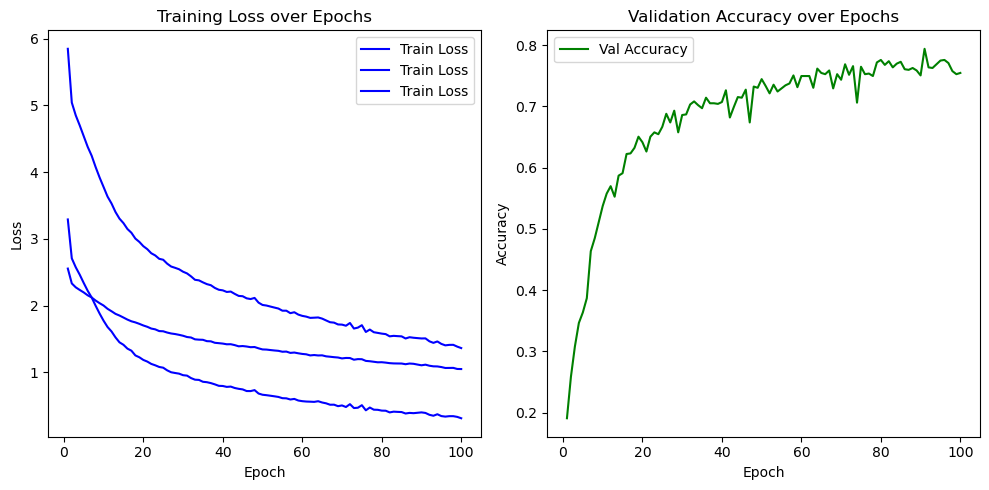

In [53]:
import matplotlib.pyplot as plt

epochs = range(1, 101)  # 100 epochs

plt.figure(figsize=(10, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()

# Plot validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accuracies, label='Val Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


## MULTIMODAL

In [30]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim),
            nn.ReLU()
        )
    def forward(self, x):
        return self.net(x)

In [31]:
class MultiModalModel(nn.Module):
    def __init__(self, input_dims, num_diagnosis, num_stages, hidden_dim=64, embedding_dim=32):
        super(MultiModalModel, self).__init__()

        self.clinical_mlp = MLP(input_dims['clinical'], hidden_dim, embedding_dim)
        self.molecular_mlp = MLP(input_dims['molecular'], hidden_dim, embedding_dim)
        self.pathology_mlp = MLP(input_dims['pathology'], hidden_dim, embedding_dim)

        concat_dim = embedding_dim * 3

        self.stage_classifier = nn.Sequential(
            nn.Linear(concat_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_stages)
        )

        self.diagnosis_classifier = nn.Sequential(
            nn.Linear(concat_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, num_diagnosis)
        )

    def forward(self, clinical_x, molecular_x, pathology_x):
        clinical_embed = self.clinical_mlp(clinical_x)
        molecular_embed = self.molecular_mlp(molecular_x)
        pathology_embed = self.pathology_mlp(pathology_x)

        combined = torch.cat([clinical_embed, molecular_embed, pathology_embed], dim=1)
        diagnosis_out = self.diagnosis_classifier(combined)
        stage_out = self.stage_classifier(combined)

        return diagnosis_out, stage_out

In [32]:
from torch.utils.data import Dataset
import numpy as np
import torch

class MultiModalDataset(Dataset):
    def __init__(self, dataset_df, survival_days=730):
        self.samples = []
        
        for row in dataset_df.itertuples():
            stage = getattr(row, 'ajcc_pathologic_stage_ord')
            diagnosis = getattr(row, 'primary_diagnosis_ord')
            if stage is not None and diagnosis is not None:
                # Clinical Data Processing
                clinical_embedding = np.frombuffer(getattr(row, 'embedding_clin'), dtype=np.float32)
                clinical_embedding = clinical_embedding.reshape(getattr(row, 'embedding_shape_clin')).squeeze()
                
                # Molecular Data Processing
                molecular_embedding = getattr(row, 'embedding_mol').squeeze()
                
                # Pathology Data Processing
                pathology_embedding = np.frombuffer(getattr(row, 'embedding_path'), dtype=np.float32)
                pathology_embedding = pathology_embedding.reshape(getattr(row, 'embedding_shape_path')).squeeze()
                
                # Add the combined data and label to the sample list
                self.samples.append((clinical_embedding, molecular_embedding, pathology_embedding, diagnosis, stage))

    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        clinical_embedding, molecular_embedding, pathology_embedding, diagnosis, stage = self.samples[idx]
        return (torch.tensor(clinical_embedding, dtype=torch.float32), 
                torch.tensor(molecular_embedding, dtype=torch.float32), 
                torch.tensor(pathology_embedding, dtype=torch.float32), 
                torch.tensor(diagnosis, dtype=torch.int32).type(torch.LongTensor),
                torch.tensor(stage, dtype=torch.int32).type(torch.LongTensor))


In [5]:
clinical_dataset = load_dataset("Lab-Rasool/TCGA", "clinical", split="gatortron")
pathology_report_dataset = load_dataset("Lab-Rasool/TCGA", "pathology_report", split="gatortron")
molecular_dataset = load_dataset("Lab-Rasool/TCGA", "molecular", split="senmo")

### Data Merging

In [33]:
clinical_dataset

Dataset({
    features: ['project_id', 'case_id', 'case_submitter_id', 'selected_normal_wgs', 'source_center', 'state', 'a260_a280_ratio', 'normal_tumor_genotype_snp_match', 'ribosomal_rna_28s_16s_ratio', 'rna_integrity_number', 'age_at_index', 'days_to_birth', 'days_to_death', 'ethnicity', 'gender', 'race', 'vital_status', 'year_of_birth', 'year_of_death', 'age_at_diagnosis', 'ajcc_clinical_m', 'ajcc_pathologic_n', 'ajcc_pathologic_stage', 'ajcc_pathologic_t', 'classification_of_tumor', 'days_to_diagnosis', 'icd_10_code', 'last_known_disease_status', 'morphology', 'primary_diagnosis', 'prior_malignancy', 'prior_treatment', 'progression_or_recurrence', 'site_of_resection_or_biopsy', 'synchronous_malignancy', 'tissue_or_organ_of_origin', 'tumor_grade', 'year_of_diagnosis', 'treatment_or_therapy', 'alcohol_history', 'is_ffpe', 'composition', 'days_to_collection', 'days_to_sample_procurement', 'initial_weight', 'pathology_report_uuid', 'portion_submitter_id', 'percent_lymphocyte_infiltrat

In [6]:
for col in clinical_dataset.column_names:
    print(f'{col}: {clinical_dataset[col].count(None)}')

project_id: 0
case_id: 0
case_submitter_id: 0
selected_normal_wgs: 4426
source_center: 2912
state: 0
a260_a280_ratio: 6446
normal_tumor_genotype_snp_match: 1705
ribosomal_rna_28s_16s_ratio: 3709
rna_integrity_number: 4242
age_at_index: 205
days_to_birth: 273
days_to_death: 7824
ethnicity: 148
gender: 148
race: 148
vital_status: 148
year_of_birth: 321
year_of_death: 8721
age_at_diagnosis: 273
ajcc_clinical_m: 9578
ajcc_pathologic_n: 3487
ajcc_pathologic_stage: 4354
ajcc_pathologic_t: 3426
classification_of_tumor: 148
days_to_diagnosis: 389
icd_10_code: 352
last_known_disease_status: 261
morphology: 148
primary_diagnosis: 148
prior_malignancy: 148
prior_treatment: 148
progression_or_recurrence: 261
site_of_resection_or_biopsy: 148
synchronous_malignancy: 260
tissue_or_organ_of_origin: 148
tumor_grade: 148
year_of_diagnosis: 281
treatment_or_therapy: 3648
alcohol_history: 261
is_ffpe: 68
composition: 1716
days_to_collection: 5030
days_to_sample_procurement: 1787
initial_weight: 5265
patho

In [33]:
# Examine how many times each patient ID shows up
clin_counts = defaultdict(int)
for id in clinical_dataset['case_submitter_id']:
    clin_counts[id] += 1
print(clin_counts)
print(f'There are {len(clin_counts)} PatientIDs')
print("Does each ID show up once?: ", all(count == 1 for count in list(clin_counts.values())))

# Print the ones that show multiple times
clin_anomalies = dict()
for id, count in clin_counts.items():
    if count != 1:
        clin_anomalies[id] = count
print(clin_anomalies)
print(f'{len(clin_anomalies)} PatientIDs were present > 1 times')

defaultdict(<class 'int'>, {'TCGA-OR-A5J1': 1, 'TCGA-OR-A5J2': 1, 'TCGA-OR-A5J3': 1, 'TCGA-OR-A5J4': 1, 'TCGA-OR-A5J5': 1, 'TCGA-OR-A5J6': 1, 'TCGA-OR-A5J7': 1, 'TCGA-OR-A5J8': 1, 'TCGA-OR-A5J9': 1, 'TCGA-OR-A5JA': 1, 'TCGA-OR-A5JB': 1, 'TCGA-OR-A5JC': 1, 'TCGA-OR-A5JD': 1, 'TCGA-OR-A5JE': 1, 'TCGA-OR-A5JF': 1, 'TCGA-OR-A5JG': 1, 'TCGA-OR-A5JH': 1, 'TCGA-OR-A5JI': 1, 'TCGA-OR-A5JJ': 1, 'TCGA-OR-A5JK': 1, 'TCGA-OR-A5JL': 1, 'TCGA-OR-A5JM': 1, 'TCGA-OR-A5JO': 1, 'TCGA-OR-A5JP': 1, 'TCGA-OR-A5JQ': 1, 'TCGA-OR-A5JR': 1, 'TCGA-OR-A5JS': 1, 'TCGA-OR-A5JT': 1, 'TCGA-OR-A5JU': 1, 'TCGA-OR-A5JV': 1, 'TCGA-OR-A5JW': 1, 'TCGA-OR-A5JX': 1, 'TCGA-OR-A5JY': 1, 'TCGA-OR-A5JZ': 1, 'TCGA-OR-A5K0': 1, 'TCGA-OR-A5K1': 1, 'TCGA-OR-A5K2': 1, 'TCGA-OR-A5K3': 1, 'TCGA-OR-A5K4': 1, 'TCGA-OR-A5K5': 1, 'TCGA-OR-A5K6': 1, 'TCGA-OR-A5K8': 1, 'TCGA-OR-A5K9': 1, 'TCGA-OR-A5KB': 1, 'TCGA-OR-A5KO': 1, 'TCGA-OR-A5KP': 1, 'TCGA-OR-A5KQ': 1, 'TCGA-OR-A5KS': 1, 'TCGA-OR-A5KT': 1, 'TCGA-OR-A5KU': 1, 'TCGA-OR-A5KV': 1, 'TC

In [26]:
pathology_report_dataset

Dataset({
    features: ['id', 'data_format', 'access', 'file_name', 'md5sum', 'updated_datetime', 'data_type', 'data_category', 'state', 'type', 'file_size', 'created_datetime', 'PatientID', 'gdc_case_id', 'report_text', 'embedding', 'embedding_shape'],
    num_rows: 11208
})

In [34]:
# Examine how many times each patient ID shows up
path_counts = defaultdict(int)
for id in pathology_report_dataset['PatientID']:
    path_counts[id] += 1
print(path_counts)
print(f'There are {len(path_counts)} PatientIDs')
print("Does each ID show up once?: ", all(count == 1 for count in list(path_counts.values())))

# Print the ones that show multiple times
path_anomalies = dict()
for id, count in path_counts.items():
    if count != 1:
        path_anomalies[id] = count
print(path_anomalies)
print(f'{len(path_anomalies)} PatientIDs were present > 1 times')

defaultdict(<class 'int'>, {'TCGA-P6-A5OG': 1, 'TCGA-OR-A5J7': 1, 'TCGA-OR-A5KS': 1, 'TCGA-OR-A5LL': 1, 'TCGA-OR-A5KB': 1, 'TCGA-OR-A5JP': 1, 'TCGA-OR-A5J8': 1, 'TCGA-OR-A5JL': 1, 'TCGA-OR-A5K8': 1, 'TCGA-OR-A5LO': 1, 'TCGA-OR-A5K6': 1, 'TCGA-OR-A5KV': 1, 'TCGA-OR-A5JD': 1, 'TCGA-OR-A5JQ': 1, 'TCGA-OR-A5L5': 1, 'TCGA-OR-A5LT': 1, 'TCGA-OR-A5KX': 1, 'TCGA-OR-A5JV': 1, 'TCGA-OR-A5L1': 1, 'TCGA-OR-A5JY': 1, 'TCGA-OR-A5KU': 1, 'TCGA-OR-A5JX': 1, 'TCGA-PK-A5H8': 1, 'TCGA-OR-A5JA': 1, 'TCGA-OR-A5JH': 1, 'TCGA-OR-A5JO': 1, 'TCGA-OR-A5LN': 1, 'TCGA-PK-A5HA': 1, 'TCGA-OR-A5J4': 1, 'TCGA-OR-A5L8': 1, 'TCGA-OR-A5KY': 1, 'TCGA-OR-A5JW': 1, 'TCGA-OR-A5KP': 1, 'TCGA-OR-A5KW': 1, 'TCGA-OR-A5K2': 1, 'TCGA-OR-A5JG': 1, 'TCGA-OR-A5J5': 1, 'TCGA-OR-A5K4': 1, 'TCGA-OR-A5LR': 1, 'TCGA-OR-A5LF': 1, 'TCGA-OR-A5JS': 1, 'TCGA-PK-A5H9': 1, 'TCGA-P6-A5OF': 1, 'TCGA-PA-A5YG': 1, 'TCGA-PK-A5HC': 1, 'TCGA-OR-A5L4': 1, 'TCGA-OR-A5J2': 1, 'TCGA-P6-A5OH': 1, 'TCGA-OR-A5JZ': 1, 'TCGA-OR-A5KZ': 1, 'TCGA-PK-A5HB': 1, 'TC

In [27]:
molecular_dataset

Dataset({
    features: ['PatientID', 'SampleID', 'Embeddings'],
    num_rows: 13804
})

In [35]:
# Examine how many times each patient ID shows up
mol_counts = defaultdict(int)
for id in molecular_dataset['PatientID']:
    mol_counts[id] += 1
print(mol_counts)
print(f'There are {len(mol_counts)} PatientIDs')
print("Does each ID show up once?: ", all(count == 1 for count in list(mol_counts.values())))

# Print the ones that show multiple times
mol_anomalies = dict()
for id, count in mol_counts.items():
    if count != 1:
        mol_anomalies[id] = count
print(mol_anomalies)
print(f'{len(mol_anomalies)} PatientIDs were present > 1 times')

defaultdict(<class 'int'>, {'TCGA-02-0001': 1, 'TCGA-02-0009': 1, 'TCGA-02-0021': 1, 'TCGA-02-0024': 1, 'TCGA-02-0026': 1, 'TCGA-02-0028': 1, 'TCGA-02-0033': 1, 'TCGA-02-0038': 1, 'TCGA-02-0043': 1, 'TCGA-02-0046': 1, 'TCGA-02-0051': 1, 'TCGA-02-0060': 1, 'TCGA-02-0064': 1, 'TCGA-02-0069': 1, 'TCGA-02-0070': 1, 'TCGA-02-0071': 1, 'TCGA-02-0075': 1, 'TCGA-02-0079': 1, 'TCGA-02-0080': 1, 'TCGA-02-0084': 1, 'TCGA-02-0086': 1, 'TCGA-02-0089': 1, 'TCGA-02-0102': 1, 'TCGA-02-0107': 1, 'TCGA-02-0111': 1, 'TCGA-02-0113': 1, 'TCGA-02-0114': 1, 'TCGA-02-0116': 1, 'TCGA-02-0285': 1, 'TCGA-02-0290': 1, 'TCGA-02-0317': 1, 'TCGA-02-0321': 1, 'TCGA-02-0326': 1, 'TCGA-02-0337': 1, 'TCGA-02-0339': 1, 'TCGA-02-0432': 1, 'TCGA-02-0440': 1, 'TCGA-02-0451': 1, 'TCGA-02-2486': 1, 'TCGA-04-1335': 2, 'TCGA-04-1336': 2, 'TCGA-04-1337': 2, 'TCGA-04-1341': 1, 'TCGA-04-1342': 2, 'TCGA-04-1346': 2, 'TCGA-04-1348': 2, 'TCGA-04-1349': 2, 'TCGA-04-1350': 2, 'TCGA-04-1353': 2, 'TCGA-04-1356': 2, 'TCGA-04-1361': 2, 'TC

In [ ]:
# Clearly most of these only show up once, even if the sample letter makes it seem as if there may be more
sorted(molecular_dataset['SampleID'])

In [36]:
# Compute the final intersection of IDs to form our dataset. We want to exclude anomalies from each set and then
# find the intersection

clin_set = set(list(clin_counts.keys())) - set(list(clin_anomalies.keys()))
path_set = set(list(path_counts.keys())) - set(list(path_anomalies.keys()))
mol_set = set(list(mol_counts.keys())) - set(list(mol_anomalies.keys()))

final_ids = mol_set.intersection(path_set, clin_set)
print(len(final_ids))

8413


In [37]:
print(set(pathology_report_dataset.column_names).intersection(set(clinical_dataset.column_names)))
print(set(pathology_report_dataset.column_names).intersection(set(molecular_dataset.column_names)))
print(set(clinical_dataset.column_names).intersection(set(molecular_dataset.column_names)))

{'embedding', 'embedding_shape', 'state'}
{'PatientID'}
set()


In [38]:
# Now we want to remove all the ids not in final_ids from each of the datasets
# also rename colliding columns so things are clear after joining
clinical_filtered = clinical_dataset.filter(
    lambda x: x['case_submitter_id'] in final_ids
).rename_columns({'embedding': 'embedding_clin', 'embedding_shape': 'embedding_shape_clin', 'state': 'state_clin'}).to_pandas()
pathology_filtered = pathology_report_dataset.filter(
    lambda x: x['PatientID'] in final_ids
).rename_columns({'embedding': 'embedding_path', 'embedding_shape': 'embedding_shape_path', 'state': 'state_path'}).to_pandas()
molecular_filtered = molecular_dataset.filter(
    lambda x: x['PatientID'] in final_ids,
).rename_column('Embeddings', 'embedding_mol').to_pandas()

In [39]:
# Join on the PatientID
intermediate_merge = pathology_filtered.merge(clinical_filtered, how='inner', left_on='PatientID', right_on='case_submitter_id')
merged_dataset = intermediate_merge.merge(molecular_filtered, how='inner', on='PatientID')

In [42]:
# Give ordinal encodings to the label columns
merged_dataset = merged_dataset.dropna(subset=['primary_diagnosis', 'ajcc_pathologic_stage'])
merged_dataset['primary_diagnosis_ord'] = pd.factorize(merged_dataset['primary_diagnosis'])[0]
merged_dataset['ajcc_pathologic_stage_ord'] = pd.factorize(merged_dataset['ajcc_pathologic_stage'])[0]

In [44]:
len(merged_dataset)

4948

### Run Multitask Model

In [43]:
multidataset = MultiModalDataset(merged_dataset)

In [45]:
# 2. Get input dimensions
sample = multidataset[0]
print(sample[0].shape)
print(sample[1].shape)
print(sample[2].shape)
clinical_dim = sample[0].shape[0]
molecular_dim = sample[1].shape[0]
pathology_dim = sample[2].shape[0]

input_dims = {
    'clinical': clinical_dim,
    'molecular': molecular_dim,
    'pathology': pathology_dim
}

model = MultiModalModel(input_dims, int(np.max(merged_dataset['primary_diagnosis_ord'])) + 1, int(np.max(merged_dataset['ajcc_pathologic_stage_ord'])) + 1).to(device)  # or .to(device) if you're managing device explicitly

torch.Size([1024])
torch.Size([48])
torch.Size([1024])


In [46]:
# Split into train and val
train_size = int(0.8 * len(multidataset))
val_size = len(multidataset) - train_size
train_dataset_multi, val_dataset_multi = random_split(multidataset, [train_size, val_size])

train_loader_multi = DataLoader(train_dataset_multi, batch_size=64, shuffle=True)
val_loader_multi = DataLoader(val_dataset_multi, batch_size=64)

print(next(iter(train_loader_multi))[0].shape)
print(next(iter(train_loader_multi))[1].shape)
print(next(iter(train_loader_multi))[2].shape)
print(next(iter(train_loader_multi))[3].shape)

torch.Size([64, 1024])
torch.Size([64, 48])
torch.Size([64, 1024])
torch.Size([64])


In [47]:
criterion_diagnosis = nn.CrossEntropyLoss()
criterion_stage = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [48]:
merged_dataset['ajcc_pathologic_stage_ord'].min()

np.int64(0)

In [49]:
def train_multi(model, loader, optimizer, criterion_diagnosis, criterion_stage, device):
    model.train()
    total_loss, total_diag_loss, total_stage_loss = 0, 0, 0
    
    for batch in loader:
        clinical_x, molecular_x, pathology_x, diagnosis, stage = batch
        clinical_x = clinical_x.to(device)
        molecular_x = molecular_x.to(device)
        pathology_x = pathology_x.to(device)
        diagnosis = diagnosis.to(device)
        stage = stage.to(device)

        optimizer.zero_grad()
        diagnosis_output, stage_output = model(clinical_x, molecular_x, pathology_x)

        loss_diag = criterion_diagnosis(diagnosis_output, diagnosis)
        loss_stage = criterion_stage(stage_output, stage)
        loss = loss_diag + loss_stage

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_diag_loss += loss_diag.item()
        total_stage_loss += loss_stage.item()

    return total_loss / len(loader), total_diag_loss / len(loader), total_stage_loss / len(loader)


def evaluate_multi(model, loader, criterion_diagnosis, criterion_stage, device):
    model.eval()
    total_loss, total_diag_loss, total_stage_loss = 0, 0, 0
    total_correct_diag = 0
    total = 0

    with torch.no_grad():
        for batch in loader:
            clinical_x, molecular_x, pathology_x, diagnosis, stage = batch
            clinical_x = clinical_x.to(device)
            molecular_x = molecular_x.to(device)
            pathology_x = pathology_x.to(device)
            diagnosis = diagnosis.to(device)
            stage = stage.to(device)

            diagnosis_output, stage_output = model(clinical_x, molecular_x, pathology_x)

            loss_diag = criterion_diagnosis(diagnosis_output, diagnosis)
            loss_stage = criterion_stage(stage_output, stage)
            loss = loss_diag + loss_stage

            total_loss += loss.item()
            total_diag_loss += loss_diag.item()
            total_stage_loss += loss_stage.item()

            # Compute accuracy for diagnosis
            _, predicted_diag = torch.max(diagnosis_output, 1)
            total_correct_diag += (predicted_diag == diagnosis).sum().item()
            total += diagnosis.size(0)

    diagnosis_accuracy = total_correct_diag / total
    return (total_loss / len(loader),
            total_diag_loss / len(loader),
            total_stage_loss / len(loader),
            diagnosis_accuracy)


In [50]:
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_diag_loss, train_stage_loss = train_multi(
        model, train_loader_multi, optimizer,
        criterion_diagnosis, criterion_stage, device
    )
    
    val_loss, val_diag_loss, val_stage_loss, val_diag_acc = evaluate_multi(
        model, val_loader_multi,
        criterion_diagnosis, criterion_stage, device
    )


    train_losses.append((train_loss, train_diag_loss, train_stage_loss))
    val_losses.append((val_loss, val_diag_loss, val_stage_loss))
    val_accuracies.append(val_diag_acc)

    print(f"Epoch {epoch+1}/{num_epochs} - "
          f"Train Loss: {train_loss:.4f} | Train Diagnosis Loss: {train_diag_loss:.4f} | Train Stage Loss: {train_stage_loss:.4f} || "
          f"Val Loss: {val_loss:.4f} | Val Diagnosis Acc: {val_diag_acc:.4f} | Val Diagnosis Loss: {val_diag_loss:.4f} | Val Stage Loss: {val_stage_loss:.4f}")


Epoch 1/100 - Train Loss: 5.8479 | Train Diagnosis Loss: 3.2919 | Train Stage Loss: 2.5560 || Val Loss: 5.1530 | Val Diagnosis Acc: 0.1909 | Val Diagnosis Loss: 2.7905 | Val Stage Loss: 2.3625
Epoch 2/100 - Train Loss: 5.0426 | Train Diagnosis Loss: 2.7090 | Train Stage Loss: 2.3336 || Val Loss: 4.8932 | Val Diagnosis Acc: 0.2586 | Val Diagnosis Loss: 2.6064 | Val Stage Loss: 2.2867
Epoch 3/100 - Train Loss: 4.8500 | Train Diagnosis Loss: 2.5751 | Train Stage Loss: 2.2749 || Val Loss: 4.7368 | Val Diagnosis Acc: 0.3081 | Val Diagnosis Loss: 2.4978 | Val Stage Loss: 2.2390
Epoch 4/100 - Train Loss: 4.6998 | Train Diagnosis Loss: 2.4641 | Train Stage Loss: 2.2357 || Val Loss: 4.6197 | Val Diagnosis Acc: 0.3465 | Val Diagnosis Loss: 2.4100 | Val Stage Loss: 2.2096
Epoch 5/100 - Train Loss: 4.5395 | Train Diagnosis Loss: 2.3407 | Train Stage Loss: 2.1988 || Val Loss: 4.4562 | Val Diagnosis Acc: 0.3636 | Val Diagnosis Loss: 2.2825 | Val Stage Loss: 2.1736
Epoch 6/100 - Train Loss: 4.3793 | 

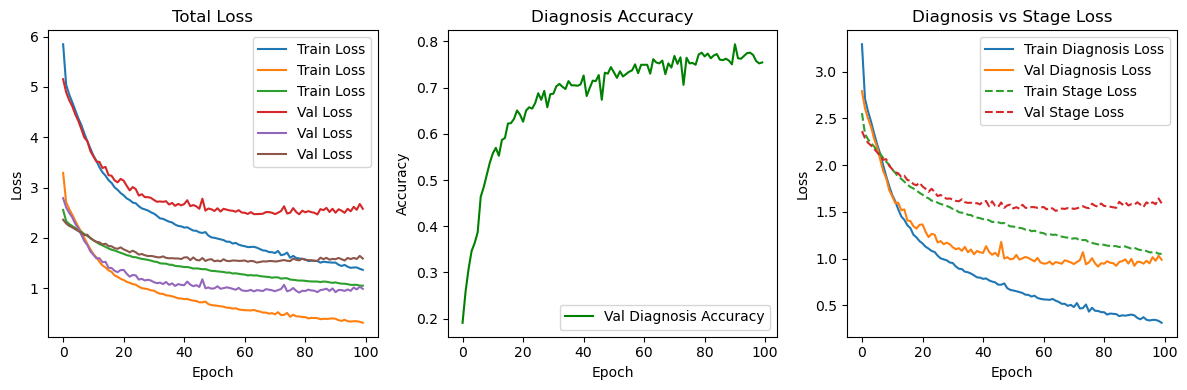

In [54]:
import matplotlib.pyplot as plt
# Plot total training and validation loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Total Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot diagnosis accuracy
plt.subplot(1, 3, 2)
plt.plot(val_accuracies, label='Val Diagnosis Accuracy', color='green')
plt.title('Diagnosis Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 3, 3)
plt.plot([loss for _, loss, _ in train_losses], label='Train Diagnosis Loss')
plt.plot([loss for _, loss, _ in val_losses], label='Val Diagnosis Loss')
plt.plot([loss for _, _, loss in train_losses], label='Train Stage Loss', linestyle='--')
plt.plot([loss for _, _, loss in val_losses], label='Val Stage Loss', linestyle='--')
plt.title('Diagnosis vs Stage Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# def train_multi(model, loader):
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss, total_diag_loss, total_stage_loss = 0, 0, 0
    
    for batch in train_loader_multi:
        # batch = np.array(batch)
        # print(batch.shape)
        clinical_x, molecular_x, pathology_x, diagnosis, stage = batch
        # print(clinical_x)
        # print(molecular_x)
        # print(pathology_x)
        # print(diagnosis)
        # print(stage)
        clinical_x = clinical_x.to(device)
        molecular_x = molecular_x.to(device)
        pathology_x = pathology_x.to(device)
        diagnosis = diagnosis.to(device)
        stage = stage.to(device)


        optimizer.zero_grad()
        diagnosis_output, stage_output = model(clinical_x, molecular_x, pathology_x)
        
        # print(diagnosis_output.shape)
        # print(diagnosis_output)
        # print(diagnosis.shape)
        # print(diagnosis.dtype)
        loss_diag = criterion_diagnosis(diagnosis_output, diagnosis)
        loss_stage = criterion_stage(stage_output, stage)
        loss = loss_diag + loss_stage

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_diag_loss += loss_diag.item()
        total_stage_loss += loss_stage.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Total Loss: {total_loss:.4f} | Diagnosis Loss: {total_diag_loss:.4f} | Stage Loss: {total_stage_loss:.4f}")




In [ ]:
with torch.no_grad():
    model.eval()
    total_loss, total_diag_loss, total_stage_loss = 0, 0, 0

    for batch in val_loader_multi:
        # batch = np.array(batch)
        # print(batch.shape)
        clinical_x, molecular_x, pathology_x, diagnosis, stage = batch
        # print(clinical_x)
        # print(molecular_x)
        # print(pathology_x)
        # print(diagnosis)
        # print(stage)
        clinical_x = clinical_x.to(device)
        molecular_x = molecular_x.to(device)
        pathology_x = pathology_x.to(device)
        diagnosis = diagnosis.to(device)
        stage = stage.to(device)


        diagnosis_output, stage_output = model(clinical_x, molecular_x, pathology_x)
        
        # print(diagnosis_output.shape)
        # print(diagnosis_output)
        # print(diagnosis.shape)
        # print(diagnosis.dtype)
        loss_diag = criterion_diagnosis(diagnosis_output, diagnosis)
        loss_stage = criterion_stage(stage_output, stage)
        loss = loss_diag + loss_stage

        total_loss += loss.item()
        total_diag_loss += loss_diag.item()
        total_stage_loss += loss_stage.item()

    print(f"Epoch {epoch+1}/{num_epochs} - Total Loss: {total_loss:.4f} | Diagnosis Loss: {total_diag_loss:.4f} | Stage Loss: {total_stage_loss:.4f}")